In [5]:
import numpy as np
import pandas as pd
import astropy.io.fits as apfits
import astropy.visualization as apvis
import astropy.nddata as apnndd
import astropy.table as aptable
import astropy.wcs as apwcs
import astropy.units as apunits
import astropy.coordinates as apcoords
import pandas as pd
import matplotlib.pyplot as mplplot
import matplotlib.patches as mplpatches
import glob
import os
import scipy as sp
import scipy.optimize as spopt

import grismconf

In [6]:
!pwd

/Users/zx446701/Documents/Astro_Projects/IceAge_ERS/Spectral_Extraction_Code


### Accessing Fengwu Data Files (Ex HD)

In [7]:
frameFitsDir = "/Volumes/Elements/Zak/Fengwu_Ice_Age/F322W2/ver1_F322W2_frames"
frameListDir = "/Volumes/Elements/Zak/Fengwu_Ice_Age/F322W2/ver1_F322W2_list"
frameSpec2dDir = "/Volumes/Elements/Zak/Fengwu_Ice_Age/F322W2/extract_2d/"

#### Arrange the frames fits file list into the required format

In [13]:
# Create full list of files within folder as a list
frameFitsFiles = glob.glob(os.path.join(frameFitsDir, "*.fits")) 
# Format frameFitsFiles into a dictionary

frameFitsFiles = {
    idx: np.sort(data.to_numpy().flatten())
    for idx, data in pd.DataFrame(frameFitsFiles).groupby(
        by=pd.DataFrame(frameFitsFiles)
        .loc[:, 0]
        .apply(lambda x: "_".join(os.path.basename(x).split("_")[:3]))
    )
}

#### Define functions to extract the source list, along with sky and pixel coordinates within the images

In [14]:
# Define function to extract the source list of sources within an uncalibrated image
def getSourceListForImage(image, frameListDir):
    listPath = os.path.join(
        frameListDir,
        f"{'_'.join(os.path.basename(image).split('_')[:4])}_uncal_pointsources.list",
    )
    return pd.read_csv(listPath, delim_whitespace=True, comment="#", header=None)

In [15]:
# Define function to extract the source sky coordinates of sources within an uncalibrated image
def getSourceCoordsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir) # Use previous function within this one
    coords = apcoords.SkyCoord(
        *sourceList.loc[:, [3, 4]].to_numpy().T, frame=apcoords.ICRS, unit=apunits.deg
    )
    return coords

In [16]:
# Define function to extract the source pixel coordinates of sources within an uncalibrated image
def getSourcePixelsForImage(image, frameListDir):
    sourceList = getSourceListForImage(image, frameListDir)
    pixels = sourceList.loc[:, [5, 6]].to_numpy()
    # pixels are the 
    return pixels

### Define Function to calculate the expected trace within the image

Code taken from https://github.com/npirzkal/GRISMCONF 

In [17]:
def computeTrace(pixels, fac=100, module="A", direction="R", simYDisp=False):
    # Locate config File for the module and grism direction 
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    # Class to read and hold GRISM configuration info
    conf = grismconf.Config(confFile)
    # Found from GRISMCONF README file - see link above
    # Middle section - number of pixels from end to start in X direction
    # 1/ middle = slighting trace by number of pixels
    # /fac is for splitting by subpixel amounts
    dt = np.abs(1 / (1 + conf.DISPX("+1", *pixels, 1) - conf.DISPX("+1", *pixels, 0)) / fac)
    t = np.arange(0, 1, dt)

    # DISP(X,Y,L) = DISPERSION POLYNOMIAL (X direction, Y, Full Length)
    # order, x0, y0, steps along dispersion between 0 and 1
    # X disp polynomial
    dxs = conf.DISPX("+1", *pixels, t)
    # Y disp polynomial 
    dys = conf.DISPY("+1", *pixels, t)
    # Compute wavelength of each pixel
    wavs = conf.DISPL("+1", *pixels, t)

    return (
        pixels[0] + dxs,
        pixels[1] + dys if simYDisp else np.full_like(dys, pixels[1]),
        wavs,
    )

DO WE NEED TO ADJUST THE RETURN PER DISPERSION DIRECTION??? R AND C USING DIFFERENT DXS AND DYS?

In [18]:
def computeTraceBox(
    # Pixels of source being traced (x0, y0)
    pixels,
    # Not sure this is needed
    fac=100,
    # Change module depending on module used for observation
    module="A",
    # Change Direction depending on disperser used for observation
    direction="R",
    # Is this needed?
    simYDisp=False,
    # Box around expected trace 
    returnRect=True,
    # Height 50 pixels as PSF modelled 50x50 pixels
    height=50,
    # Need some guidance on what this is !
    **patchkws,
):
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_mod{module}_{direction}.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
    dxs = conf.DISPX("+1", *pixels, np.array([0, 1]))
    # Is the Y needed for this?
    dys = conf.DISPY("+1", *pixels, np.array([0, 1]))
    
    #Locating the centre of the trace 
    centrePix = conf.DISPX("+1", *pixels, np.array([0.5]))

    if returnRect:
        mplplot.scatter(pixels[0]+centrePix[0], pixels[1],c='green')
        return mplpatches.Rectangle(
            # x0,y0 in bottom left of rectangle
            (pixels[0] + dxs[0], pixels[1] - height // 2),
            # width of rectangle 
            dxs[1] - dxs[0],
            # height of box (PSF width 50 pixels)
            height,
            **patchkws,
        )
    return (pixels[0]+centrePix[0], pixels[1]), (height, abs(dxs[1] - dxs[0]))

### Set up required variables for code
Retrieve each sources direct pixel and sky coordinates and create a Pandas dataframe of the direct pixel coords for manipulation later.

In [19]:
# Get sources from all images loaded into notebook
for imageFits in next(iter(frameFitsFiles.values())):
    directPixels = getSourcePixelsForImage(imageFits, frameListDir)
    DPdf = pd.DataFrame(directPixels)
    sourceCoords = getSourceCoordsForImage(imageFits, frameListDir)

### Create dataframe of x pixels at which each sources trace begins and ends

In [20]:
x = []
# y = []
# print(directPixels)
for directPixel in directPixels:
    confFile = f"GRISM_NIRCAM/V2/NIRCAM_F322W2_modB_R.conf"
    conf = grismconf.Config(confFile)
    # X and Y disp polynomials with 2 steps, the start and end of the trace
#     dxs = conf.DISPX("+1", *directPixel, np.array([0, 1]))
    x.append(directPixel[0] + conf.DISPX("+1", *directPixel, np.array([0, 1])))
    # Is the Y needed for this?
#     dys = conf.DISPY("+1", *directPixel, np.array([0, 1]))
#     dys.append(int(directPixel[1] + conf.DISPY("+1", *directPixel, np.array([0, 1]))))

dfx = pd.DataFrame(x)
# Rename the columns for pixel trace start and endpoints
dfx = dfx.rename(columns = {0 : "low_WL", 1 : "high_WL"})
# The X and Y pixels coordinates of the sources
dfx["Direct_X"] = DPdf[0]
dfx["Direct_Y"] = DPdf[1]
# The Sky Coordinates of sources
dfx["RA"] = sourceCoords.ra
dfx["Dec"] = sourceCoords.dec

# Dataframe sorted by trace starting furthest to the left
dfx = dfx.sort_values(by="low_WL")
# True or false to come next
dfx

,low_WL,high_WL,Direct_X,Direct_Y,RA,Dec
2,1190.617653,-552.410235,-350.219,2761.050,166.538658,-77.368153
62,1249.267653,-493.760235,-291.569,2214.600,166.534479,-77.377783
77,1253.754653,-489.273235,-287.082,738.874,166.535792,-77.403772
27,1374.203653,-368.824235,-166.633,2821.111,166.523950,-77.367183
33,1422.069653,-320.958235,-118.767,3081.354,166.519946,-77.362617
...,...,...,...,...,...,...
60,3937.981653,2194.953765,2397.145,1928.402,166.321112,-77.382772
78,3974.255653,2231.227765,2433.419,2151.594,166.318425,-77.378878
24,4022.226653,2279.198765,2481.390,642.758,166.312492,-77.405208
35,4044.791653,2301.763765,2503.955,2744.142,166.313175,-77.368531


### Plot Check of the uploaded files 

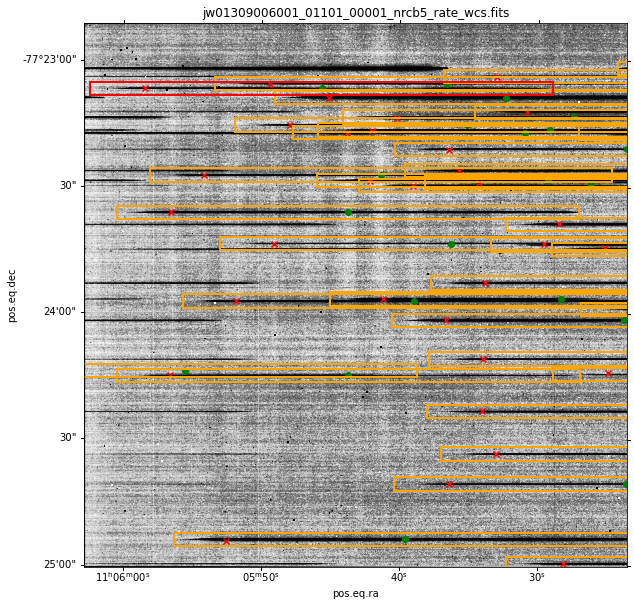

In [21]:
with apfits.open(imageFits) as test:
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
        
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
#     sourceCoords = getSourceCoordsForImage(imageFits, frameListDir)
        
         # Plot sources on FOV
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    ax.set_title(os.path.basename(imageFits))
        
#     directPixels = getSourcePixelsForImage(imageFits, frameListDir)
#     print(imageFits, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within imageFits???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox = computeTraceBox(
            directPixel,
            module=os.path.basename(imageFits).split("_")[3][-2].upper(),
            direction="R",
            ec="red" if sourceId == 55 else "orange",
            #ec="orange",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBox)
        # Removing limits shows that all sources in list have traces calculated for them
        # Therefore missing traces must be due to them missing in source list which
        # will not be a problem once NIRCam Pre-imaging has been achieved
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

### Import PSF model grid modules

In [23]:
# Use source code to look into utils etc. - Ask Hugh how he knows when to look for these libraries!
from webbpsf.utils import to_griddedpsfmodel
from webbpsf.gridded_library import display_psf_grid
# How do we justify the model number (1-5??)
# Take specific instrument, module, filter and detector PSF fits files 
# and turn into a grid of how the PSF changes with position on detector array
# NUMBER OF DETECTOR IS IN NRCA5 - 5 IS LW DETECTOR 1-4 IS SW
# ONLY 5 REQUIRED FOR WFSS AS ONLY DETECTOR ABLE TO DO THIS
grid = to_griddedpsfmodel(
    "/Volumes/Elements/Zak/Fengwu_Ice_Age/mirage_data/nircam/gridded_psf_library/nircam_nrca5_f322w2_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
)

### Plot check of data within images 
In "data", the rows are the outside of the 2d array and columns on the inside - see .data[:,100] 

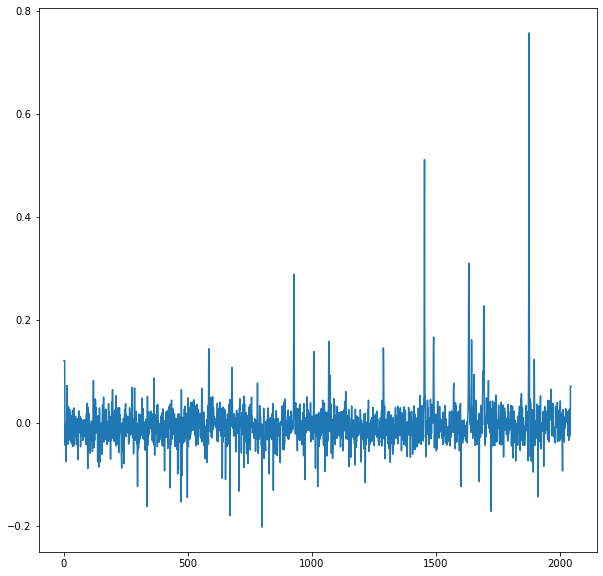

In [24]:
with apfits.open(imageFits) as test:
    data = test["SCI"].data
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, )#projection=apwcs.WCS(test["SCI"].header))    
#     ax.imshow(
#         # SCI is the images from the simulation
#         test["SCI"].data[:,100:101],
#         norm=apvis.ImageNormalize(
#             stretch=apvis.HistEqStretch(data=test["SCI"].data[:,100:101]),
#             interval=apvis.ZScaleInterval(),
#         ),
#         cmap="Greys",
#     )
    ax.plot(
    test["SCI"].data[:,100])

### Chi Squared fit function defined to find best fit parameters (Flux only at the moment)

In [164]:
# Chi squared function to test parameters fit
def fitFunction(norms, cutoutSlice, errorSlice, psfs, means):
#     figure = mplplot.figure(figsize = (15,15))
#     mplplot.plot(cutoutSlice, label='Cut')
#     mplplot.plot(errorSlice, label="err")
    selection = errorSlice > 0
    model = np.zeros_like(cutoutSlice)
    
    for norm, psf, mean in zip(norms, psfs, means):
        # May be better interpolated below
#         print(mean)
#         print(psf.size // 2)
#         print(model[max(0, int(mean) - psf.size // 2) : min(cutoutSlice.size, int(mean) + psf.size // 2)].size)
        model[int(mean) - psf.size // 2 : int(mean) + psf.size // 2] += norm * psf
#     mplplot.plot(model,label="model")
#     mplplot.legend()
    return np.nansum(
        ((model[selection] - cutoutSlice[selection]) / errorSlice[selection]) ** 2
    )


"""
Single cutout could use a defined PSF function but this is now within the code in the cell below
"""

# def simplePsfMethod(cutout, error, psfs, xDispRange, ):
#     return[
#         spopt.minimize(
#             # parameters for function as a list in square brackets - part that varies
#             # if fitting multiple sources within box, need parameters per source
#             # This is the 'norm' within fitFunction
#             fitFunction,
#             [],
#             # Arguments - the constants 
#             (cutoutSlice[xDispRange], errorSlice[xDispRange], psfs[xDispRange]),
#         ).x[0]
#         for cutoutSlice, errorSlice in zip(cutout.T, error.T)
#     ]



In [175]:
with apfits.open(imageFits) as test:
    
    # Created array for results
    result = np.zeros(shape=(dfx.shape[0],test["SCI"].data.T.shape[0]))
    grid = to_griddedpsfmodel(
    "/Volumes/Elements/Zak/Fengwu_Ice_Age/mirage_data/nircam/gridded_psf_library/nircam_nrca5_f322w2_clear_fovp47_samp5_npsf16_requirements_realization0.fits"
    )
    # Take out data per column from the image
    for column_number, (column, err_col) in enumerate(zip(test["SCI"].data.T, test["ERR"].data.T)):

        # Step 1: Work out which and how many traces there are in column to define params
        # Want all traces with a start < 0
        # How many traces are with sensitive pixels overlap the column as a boolean list
        # NASTY 30 PIXEL HACK TO STOP CRASHING - CANNOT FIT PSF FULLY TO TRACES THAT ARE 25 PIXELS FROM EDGE 
        mask = (dfx.high_WL <= column_number) & (dfx.low_WL >= column_number) & (dfx.Direct_Y >= 30) & (dfx.Direct_Y < test["SCI"].data.shape[1]-30)
        # Number of traces that overlap column
        n_params = mask.sum()
#         print(n_params)
        # Created Parameter intial values to create array for function
        params = column[dfx.Direct_Y[mask].astype(int)] 

        # Step 1.5 Extract PSF for each Source
        # Setting up grid for PSF to be plotted into around central pixel of source 
        # The PSF is only given 25 pixels in each direction (N,E,S,W) of source pixel
        # Fits files use 4TRAN notation for grids (y,x) not C notation (x,y) hence 

        # Step 2: Create required number of parameters for fitting function

        # Create 1D PSF list of all sources within the mask dependent on their position in detector
        psf_list = []
        for _, (Direct_X, Direct_Y) in dfx.loc[mask, ["Direct_X", "Direct_Y"]].iterrows():
        
            y,x = np.mgrid[
                int(Direct_Y - 25) : int(Direct_Y + 25),
                int(Direct_X - 25) : int(Direct_X + 25),

            ]

            # Need to ask where .evaluate came from!! 
            # Seems to create 2d PSF within given parameters around central point with a given flux
            # Flux seems to be arbitrary 
            # 2D array of Y axis slices divided into X axis length list
            # Shape is (70,50) so 70 arrays with 50 flux values each!
            psf2d = grid.evaluate(
                x=x, y=y, flux=1, x_0=int(Direct_X), y_0=int(Direct_Y)
            )

            psf1d = psf2d.sum(axis=1)
            psf_list.append(psf1d)


        psf_means = dfx.Direct_Y[mask]

        # Step 3: Optimise parameters of the function given the data - Returns optimised params (Flux of each trace in column), Mean (location of source) is fixed (FOR NOW!)
        
        # ACTUAL PSF METHOD TAKING PLACE! 
        
        #Optimised parameters
        opt_params = spopt.minimize(
                # parameters for function as a list in square brackets - part that varies
                # if fitting multiple sources within box, need parameters per source
                # This is the 'norm' within fitFunction
                fitFunction,
                params,
                # Arguments - the constants 
                (column, err_col, psf_list, psf_means),
            ).x

        # Step 4: Store Flux parameter outputs - associate flux with trace and column it belongs to!!!
        result[mask, column_number] = opt_params
#         print(opt_params)
        # Step 5: Next Column please Sir
    

/Volumes/Elements/Zak/Fengwu_Ice_Age/F322W2/ver1_F322W2_frames/jw01309006001_01101_00001_nrcb5_rate_wcs.fits [2481.39   642.758] [-287.082  738.874]


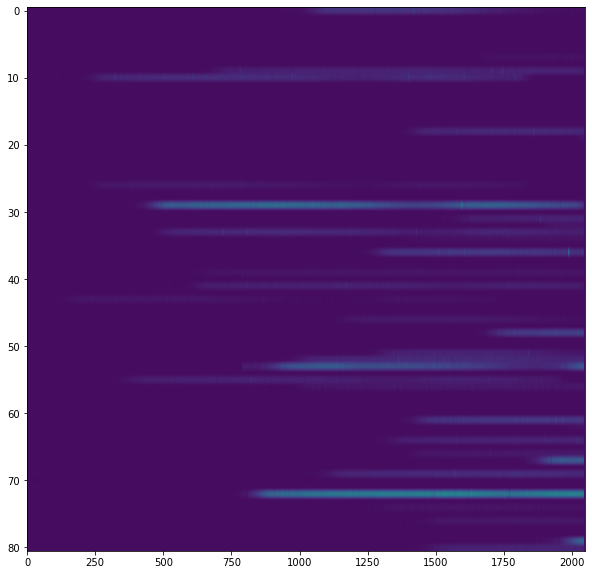

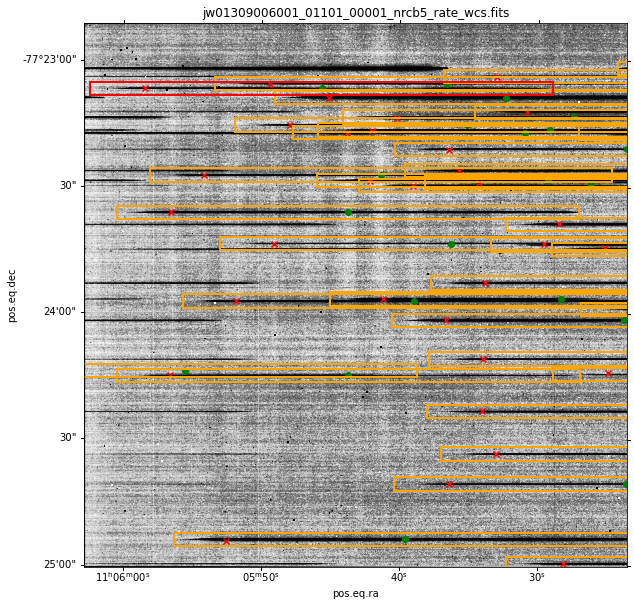

In [176]:
with apfits.open(imageFits) as test:
    mplplot.figure(figsize=(10,10))
    mplplot.imshow(result[dfx.sort_values("Direct_Y").index], aspect="auto")
    figure = mplplot.figure(figsize=(10, 10))
    ax = figure.add_subplot(1, 1, 1, projection=apwcs.WCS(test["SCI"].header))    
    ax.imshow(
        # SCI is the images from the simulation
        test["SCI"].data,
        norm=apvis.ImageNormalize(
            stretch=apvis.HistEqStretch(data=test["SCI"].data),
            interval=apvis.ZScaleInterval(),
        ),
        cmap="Greys",
    )
    # Set image limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    ax.scatter(
        sourceCoords.ra,
        sourceCoords.dec,
        marker="x",
        c="r",
        transform=ax.get_transform("world"),
    )
    ax.set_title(os.path.basename(imageFits))
        
#     directPixels = getSourcePixelsForImage(imageFits, frameListDir)
    print(imageFits, directPixels[24],directPixels[77] if len(directPixels) > 50 else "Short")
        
    # for loop to create trace boxes for each source within source list
    # HOW DO WE CHANGE FOR C DIRECTION?? NEED TO LOAD C DATA???
    # where is sourceId defined? Within imageFits???
    for sourceId, directPixel in enumerate(directPixels):
        traceBox = computeTraceBox(
            directPixel,
            module=os.path.basename(imageFits).split("_")[3][-2].upper(),
            direction="R",
            ec="red" if sourceId == 55 else "orange",
            #ec="orange",
            lw="2",
            fc="none",
        )
        ax.add_patch(traceBox)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## NEED to adjust position of applying sensitivity model for each source 

In [191]:
SensFile = apfits.open(f"GRISM_NIRCAM/V2/NIRCam.F322W2.R.A.1st.sensitivity.fits")
print(repr(SensFile[1].header)) # Units check
SensTable = aptable.Table(SensFile[1].data)
SensData_WL = SensTable[0][:]
SensData_Sens = SensTable[1][:]
SensData_Er = SensData = SensTable[2][:]

trace = computeTrace(
        (dfx.Direct_X[0], dfx.Direct_Y[0]),
        # Fac must be set to 1 to match the number of pixels across trace
        fac=1,
        module=os.path.basename(imageFits).split("_")[3][-2].upper(),
        direction="R",
    )
print(trace)

# Set up the Spectral Response Function Curve to perform Flux calibration (from ADU to Flux)
SRFCurve = sp.interpolate.interp1d(SensData_WL,SensData_Sens,kind='cubic')

print("Length of the Astropy Table =", len(SensData_Sens))

test_SRF = SRFCurve(trace[2])
print("Length of the calculated trace (NON BOX)=", len(trace[2]))
print("Length of the SRF with the calculated trace x values =", len(test_SRF))

#     extractedPanel.plot(table[0][:],table[1][:])
#     extractedPanel.plot(trace[2],test_SRF,ls='--')

# print("Length of the calculated trace (BOX)=", len(extracted))
#     data_SRF = SRFCurve(extracted)
#     print(len(extracted))
#     print(len(dataSRF))

calibratedFlux = result[::-1]/test_SRF
print(len(calibratedFlux))
    

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   24 / length of dimension 1                          
NAXIS2  =                 3541 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'WAVELENGTH'                                                          
TFORM1  = 'D       '                                                            
TTYPE2  = 'SENSITIVITY'                                                         
TFORM2  = 'D       '                                                            
TTYPE3  = 'ERROR   '        

ValueError: operands could not be broadcast together with shapes (81,2048) (1743,) 

<ipython-input-189-a75171fba06f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  mplplot.figure()


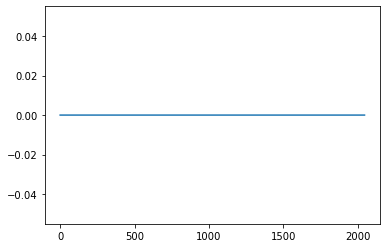

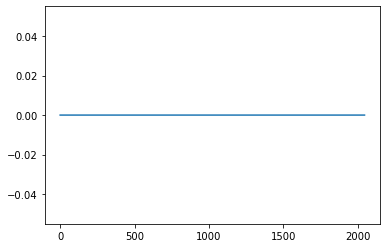

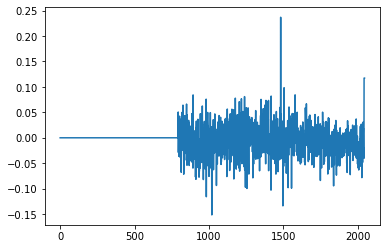

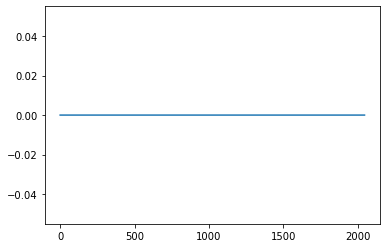

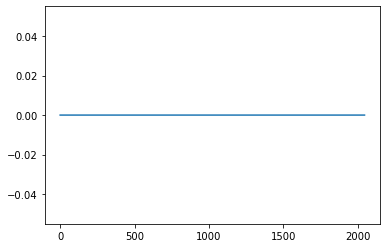

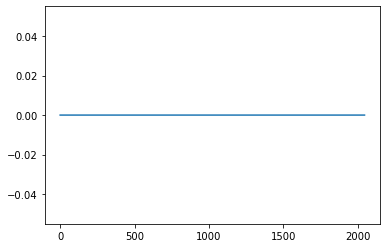

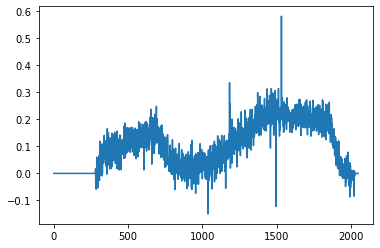

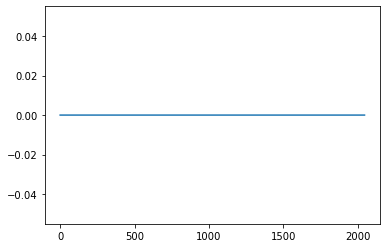

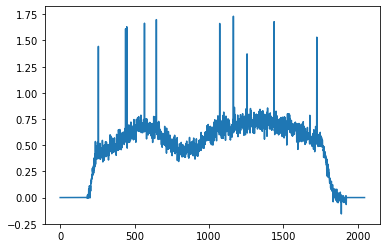

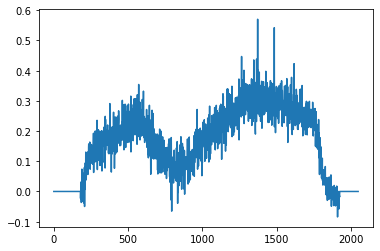

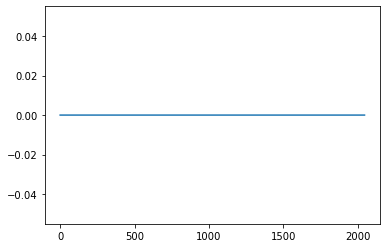

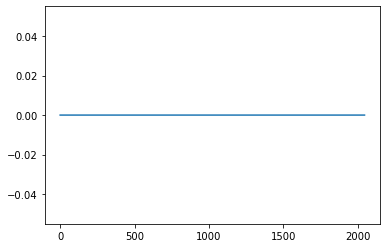

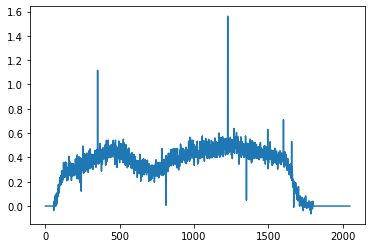

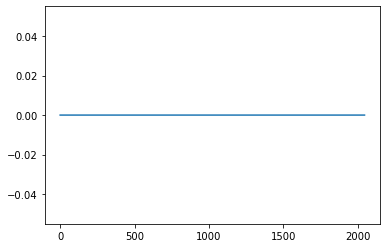

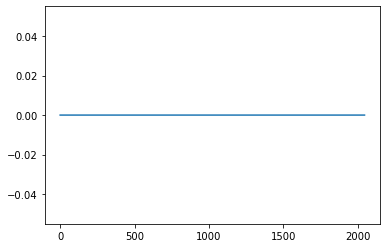

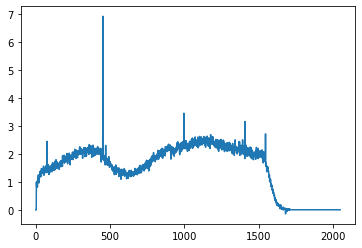

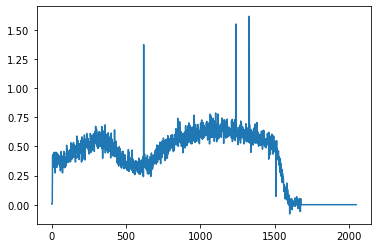

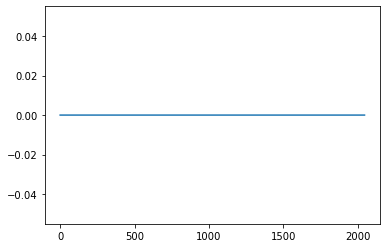

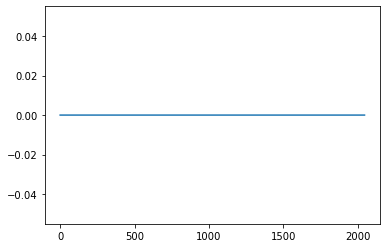

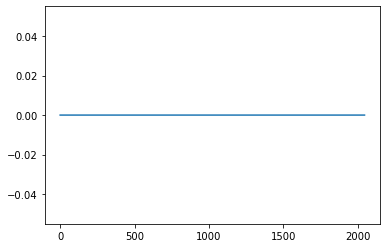

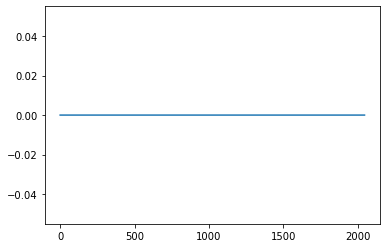

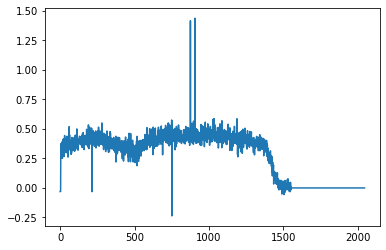

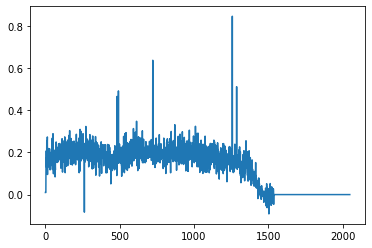

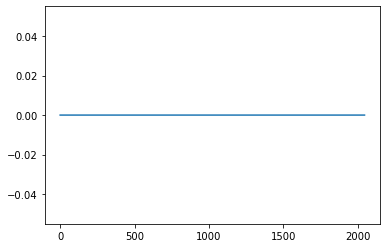

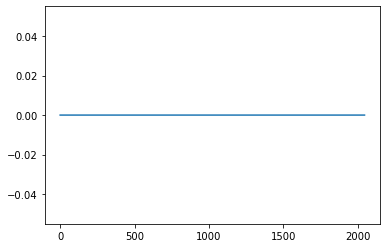

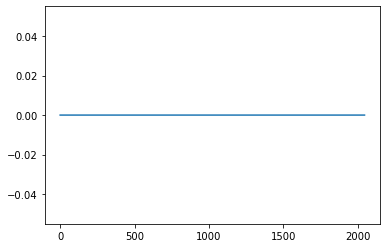

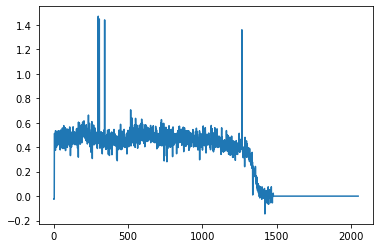

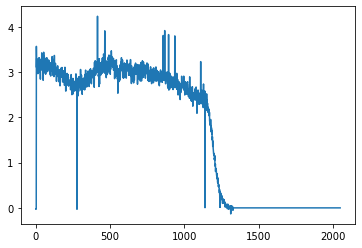

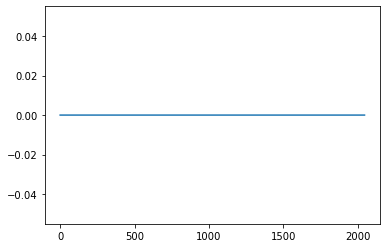

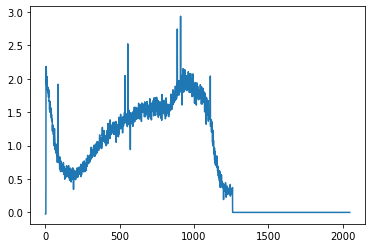

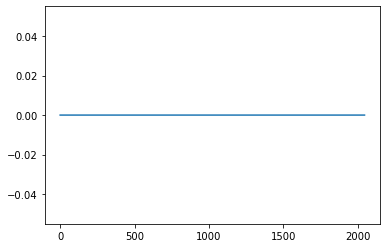

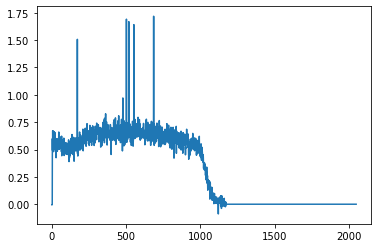

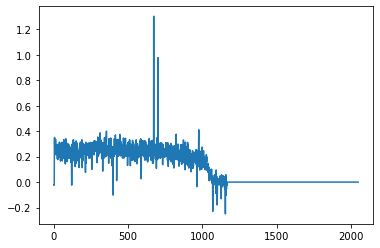

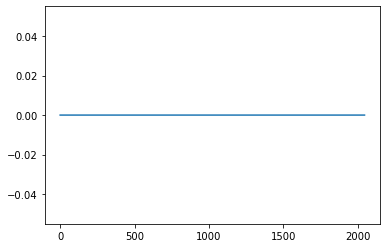

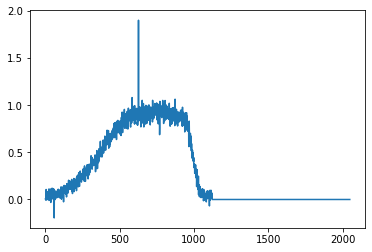

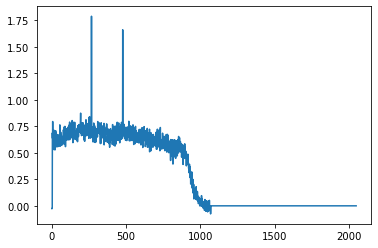

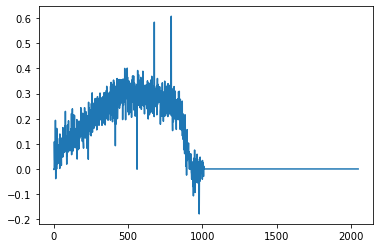

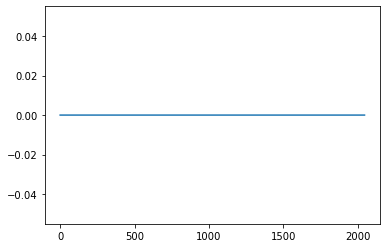

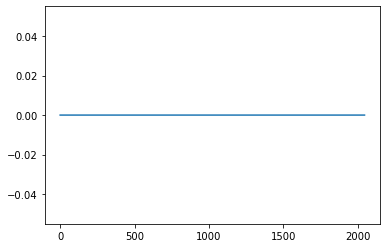

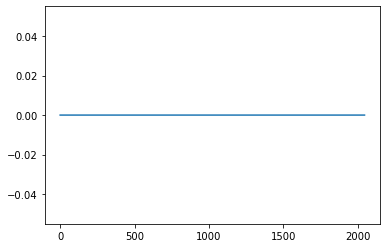

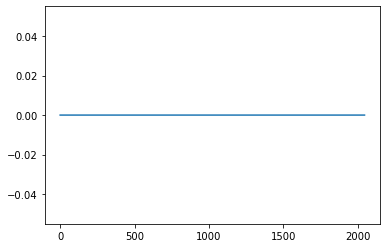

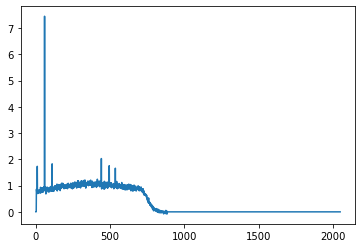

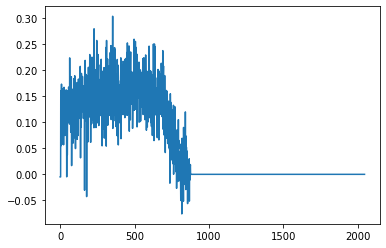

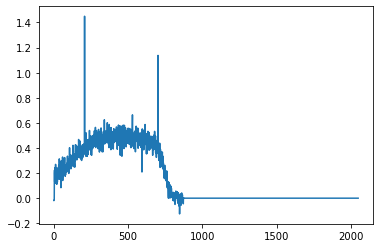

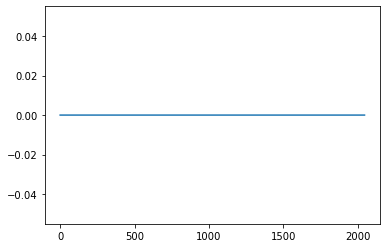

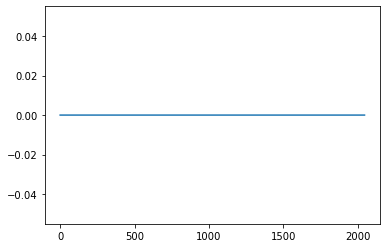

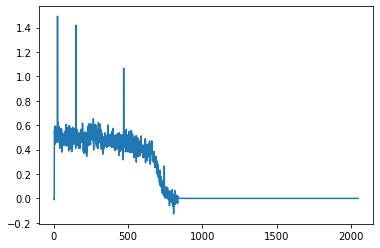

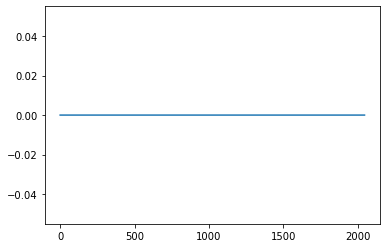

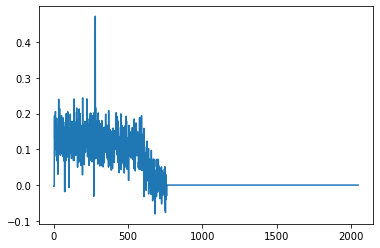

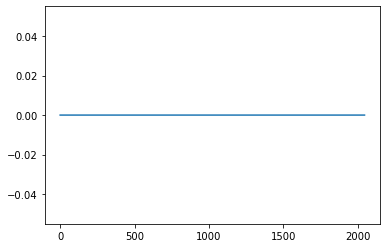

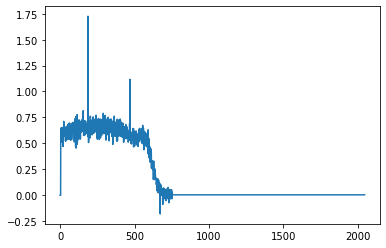

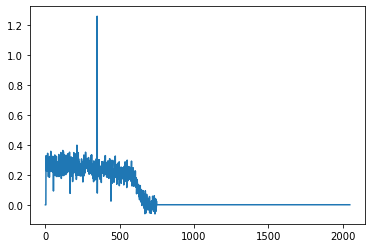

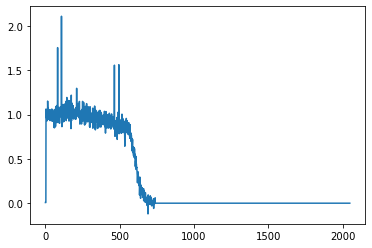

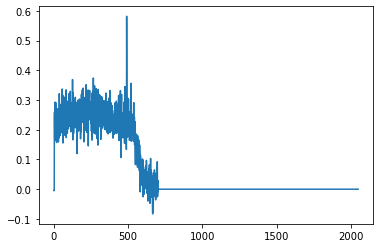

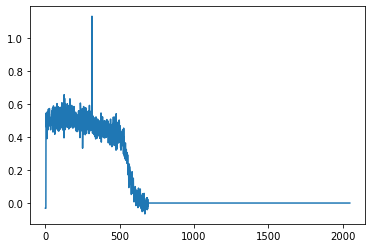

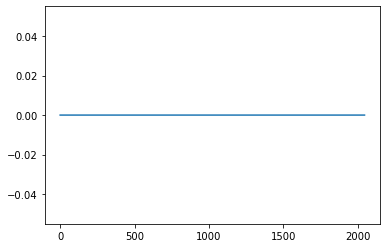

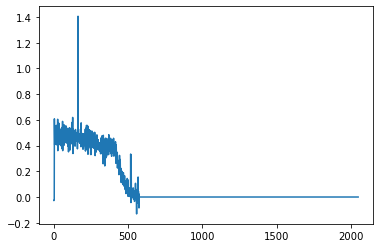

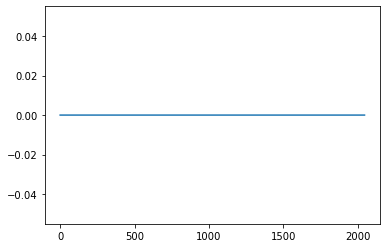

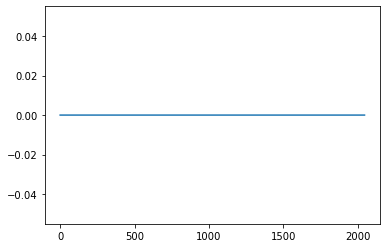

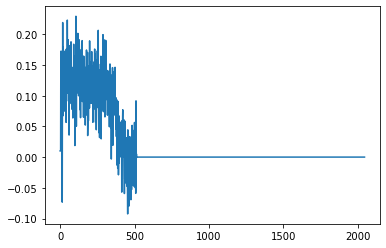

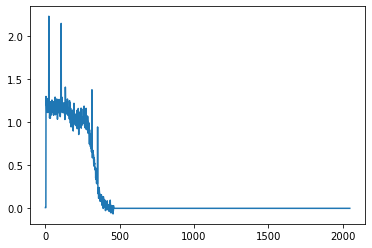

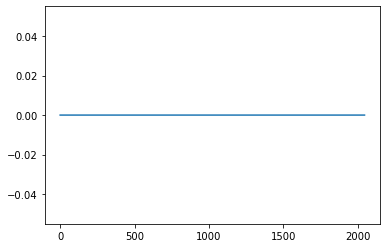

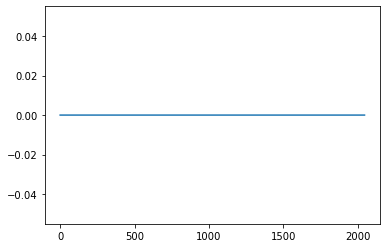

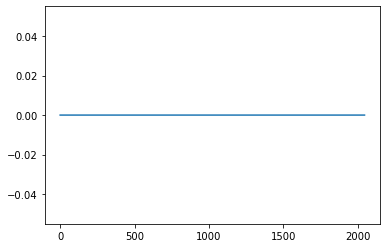

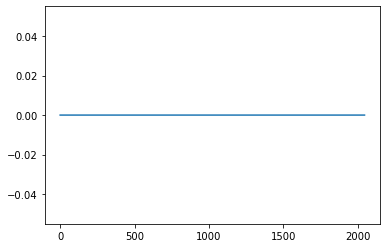

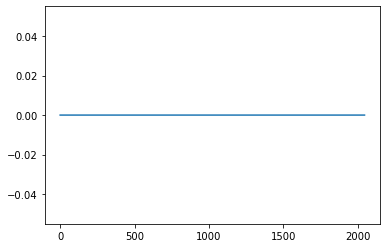

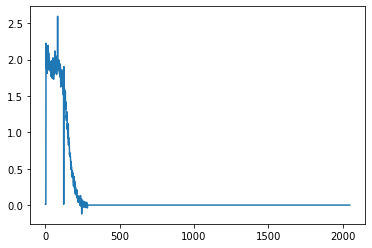

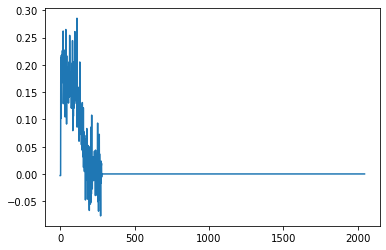

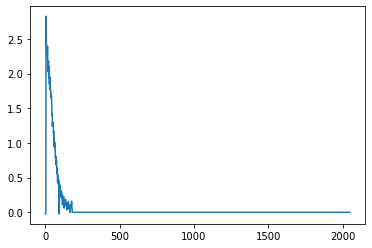

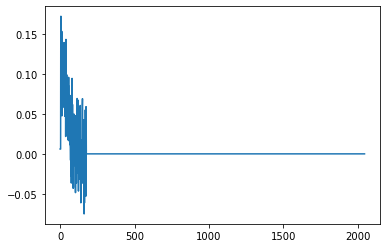

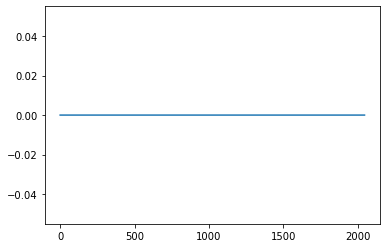

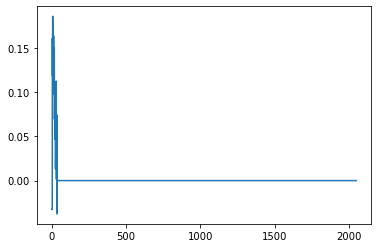

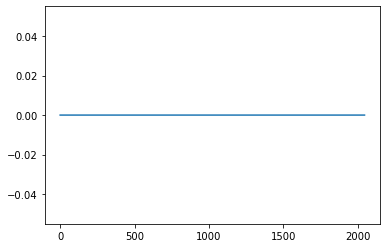

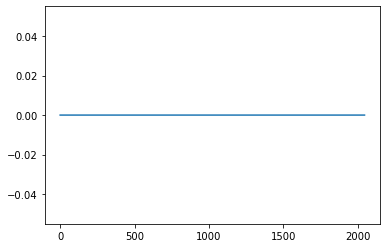

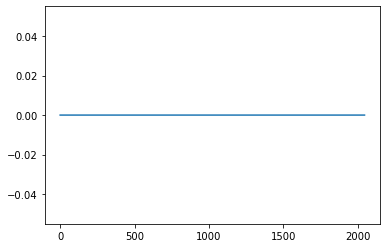

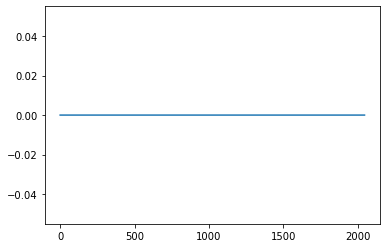

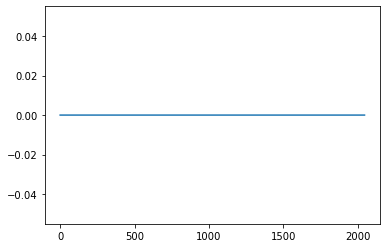

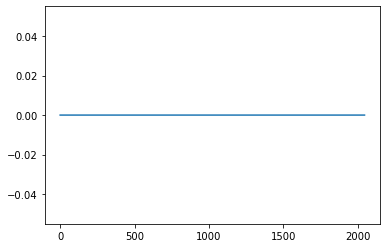

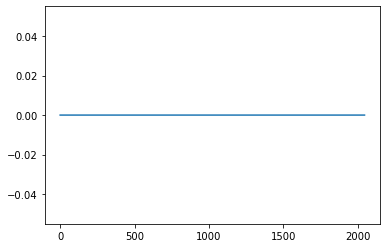

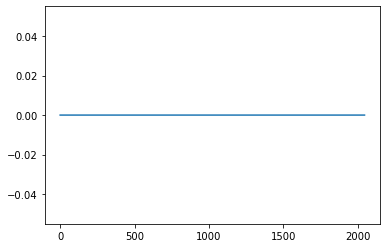

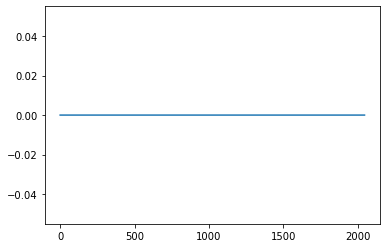

In [189]:
for sub_result in result:
    mplplot.figure()
    mplplot.plot(sub_result[::-1])